In [6]:
!pip install shap
!pip install google-generativeai
!pip install wandb

In [3]:
import numpy as np
import pandas as pd
import wandb #Wandb import
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Input, Reshape
from tensorflow.keras.callbacks import EarlyStopping
from shap import KernelExplainer, summary_plot,sample

# **Notes on data preprocessing and the method used**
Selection process of the input fields:
From Operational Parameters defined in (Cinar, Samet, Senem Onen Cinar, Nils Wieczorek, Ihsanullah Sohoo, and Kerstin Kuchta. 2021. "Integration of Artificial Intelligence into Biogas Plant Operation" Processes 9, no. 1: 85. https://doi.org/10.3390/pr9010085)
Initial selection of fields:

be_stream2methane	al_productgasoutlet_temp

pdc_powermeterphasenuetral_amps

be_ambient_tt_scaled_value	be_scg_n2

be_system_abort_shutdown

In [7]:
# """ These are the data preprocessing steps taken from the dataset provided
# import pandas as pd
# import os
# def print_hour_from_timestamp(file_path, datetime_col='timestamp'):

#     Read a CSV file and print the hour of the recorded timestamp field for each line.

#     Args:
#         file_path (str): Path to the CSV file.
#         datetime_col (str, optional): Name of the column containing the datetime values. Default is 'timestamp'.
#     # Read the CSV file
#     df = pd.read_csv(file_path,usecols=fieldnames,nrows=3000)
#     df=df.dropna()
#     # Find and convert columns with 't' or 'f' values
#     for col in df.columns:
#         if df[col].dtype == object:  # Check for text columns
#             df[col] = df[col].replace({'t': 1, 'f': 0})
#     # Convert the datetime column to datetime format if it's not already
#     if not pd.api.types.is_datetime64_any_dtype(df[datetime_col]):
#         df[datetime_col] = pd.to_datetime(df[datetime_col])
#     df = df.sort_values(by=datetime_col)
#   # Group by date and then by hour
#     grouped = df.groupby([df[datetime_col].dt.date, df[datetime_col].dt.hour , df[datetime_col].dt.minute])

#     # Get the first row of each hour within each date group
#     first_hour_data = grouped.head(1)

#     # Print the results
#     print("First hour data: ",first_hour_data)
#     return first_hour_data

# folder_name=input("Enter the folder name: ")
# folder_path = r"C:\Users\seq_amal\biogas_dataset\{}".format(folder_name)
# fieldnames= [
#     'timestamp', 'be_aircomp_overlaptime_sp', 'be_aircomp_runtime_sp', 'be_ambient_tt_scaled_value', 'be_chiller_temp_sp',
#     'be_fc1_7031_xrc2_todayvol_real', 'be_fc1_7036_xrc2_todayenergy_real', 'be_fc1_7039_xmv2_sp_psia_dint',
#     'be_fc1_7039_xmv2_sp_psia_real', 'be_fc1_7042_xrc1_todayvol_real', 'be_fc1_7047_xrc1_todayenergy_real_mmbtu',
#     'be_fc1_7050_xmv1_sp_psia_dint', 'be_fc1_7050_xmv1_sp_psia_real', 'be_in_pa001a_spare', 'be_in_pa001b_spare',
#     'be_in_spare_local6_7', 'be_in_spare_msr111_estop', 'be_productgas_ch4', 'be_system_abort_bypass',
#     'be_system_abort_recycle', 'be_system_abort_shutdown', 'be_system_abort_standby', 'be_system_offspec',
#     'be_system_running', 'be_testaoi_o_scaled_value', 'be_aircomp1_faultstatus', 'be_aircomp1_runcmd',
#     'be_aircomp1_runstatus', 'be_aircomp2_faultstatus', 'be_aircomp2_runcmd', 'be_aircomp2_runstatus',
#     'be_airliquide_faultstatus', 'be_airliquide_runcmd', 'be_airliquide_runstatus', 'be_airliquideinlet_temperature_tt499',
#     'be_carbonvesselinlet_temperature_tt496', 'be_carbonvesselinletflow_ft418', 'be_compressordischarge_pressure_pt201',
#     'be_compressorsuction_pressure_pt303', 'be_condensatelevel_lt711', 'be_dginletisolationvalve105_closed',
#     'be_dginletisolationvalve105_open', 'be_dgventgasvalve172_closed', 'be_dgventgasvalve172_open',
#     'be_digestergas_temperature_tt127', 'be_flare_faultstatus', 'be_flare_runcmd', 'be_flare_runstatus',
#     'be_flarehandvalve144_closed', 'be_flarehandvalve144_open', 'be_gdchiller_faultstatus', 'be_gdchiller_runcmd',
#     'be_gdchiller_runstatus', 'be_h2sremovalvalve181_closed', 'be_h2sremovalvalve181_open', 'be_is_vilter1_targetsp',
#     'be_is_vilter2_targetsp', 'be_instrumentair_pressure_pt826', 'be_pgoffspecreturnvalve630_closed',
#     'be_pgoffspecreturnvalve630_open', 'be_pgoutletvalve604_closed', 'be_pgoutletvalve604_open',
#     'be_pgtruckunloadvalve644_closed', 'be_pgtruckunloadvalve644_open', 'be_pgventgasvalve603_closed',
#     'be_pgventgasvalve603_open', 'be_scg_ch4', 'be_scg_co2', 'be_scg_energytotal', 'be_scg_flowindicator',
#     'be_scg_general_alarm', 'be_scg_h2s', 'be_scg_n2', 'be_scg_o2', 'be_scg_offspec_alarm', 'be_scg_offspeclatch_alarm',
#     'be_scg_online_status', 'be_scg_pressureindicator', 'be_scg_temperatureindicator', 'be_scg_totaldaily',
#     'be_stream1co2', 'be_stream1flow', 'be_stream1h2s', 'be_stream1methane', 'be_stream1n2', 'be_stream1o2',
#     'be_stream1pressure', 'be_stream1temp', 'be_stream2co2', 'be_stream2flow', 'be_stream2h2s', 'be_stream2methane',
#     'be_stream2n2', 'be_stream2o2', 'be_stream2pressure', 'be_stream2temp', 'be_stream3co2', 'be_stream3flow',
#     'be_stream3h2s', 'be_stream3methane', 'be_stream3n2', 'be_stream3o2', 'be_stream3pressure', 'be_stream3temp',
#     'be_sumplevel_lt171', 'be_sumpvalve173_closed', 'be_sumpvalve173_open', 'be_systemfault_1', 'be_systemfault_2',
#     'be_systemfault_3', 'be_vilterchiller_faultstatus', 'be_vilterchiller_runcmd', 'be_vilterchiller_runstatus',
#     'be_viltercomp1_faultstatus', 'be_viltercomp1_runcmd', 'be_viltercomp1_runstatus', 'be_viltercomp2_faultstatus',
#     'be_viltercomp2_runcmd', 'be_viltercomp2_runstatus', 'be_wastegasflow_ft437', 'al_cr_7_do', 'al_fv_3a_2b_do',
#     'al_fv_9_cmd', 'al_systemfaults_1', 'al_systemfaults_2', 'al_productgasoutlet_temp', 'al_zi_2_do', 'al_zi_5_do',
#     'al_filter2_differentialpressure', 'al_flowcontrolvalve_position', 'al_hex2filter_level', 'al_pit3_pressure',
#     'al_pit7_pressure', 'al_premembranegaso2_analyzervalue', 'al_processgasinlet_pressure', 'al_processgasinlet_temp',
#     'al_productgas_pressure', 'al_productgasco2_analyzervalue', 'al_productgaso2_analyzervalue', 'al_stage1permeate_pressure',
#     'vl_chiller_suctionscrubberinlet_pressure', 'vl_chiller_suctionscrubberoutlet_pressure',
#     'vl_chiller_dischargescrubberinlet_pressure', 'vl_chiller_dischargescrubberoutlet_pressure',
#     'vl_chiller_aftercoolerinlet_temp', 'vl_chiller_aftercooleroutlet_temp', 'vl_chiller_dischargescrubberoutlet_temp',
#     'vl_chiller_reheateroutlet_temp', 'vl_chiller_recyclevalve_position', 'pdc_powermeter3ph_watts', 'pdc_powermeterab_voltage',
#     'pdc_powermeteraan_voltage', 'pdc_powermeterbc_voltage', 'pdc_powermeterphasea_amps', 'pdc_powermeterphaseb_amps',
#     'pdc_powerpeterphasec_amps', 'pdc_powermeterphasenuetral_amps', 'fl_flamearrestor_temp', 'fl_inletvalve_closed', 'fl_inletvalve_open', 'fl_inlet_flow', 'fl_mainflame_on', 'fl_pilotflame_on', 'fl_pilotflame_temp', 'fl_propanetankvalve_open', 'fl_stackfire_temp', 'fl_stacktip_temp', 'gd_chiller_glycoltemp_sp', 'gd_chiller_reservoir_level', 'gd_chiller_returnline_temp', 'gd_chiller_supplyline_pressure', 'gd_chiller_supplyline_temp'
# ]
# output_file = r"C:\Users\seq_amal\biogas_dataset\temperory_dataset_with_timestamp_test_2.csv"
# csv_files = [file for file in os.listdir(folder_path) if file.endswith(".csv")]
# datetime_col = "timestamp"
# dates=set()
# if csv_files:
#     combined_dataset = pd.DataFrame(columns=fieldnames)

#     for file in csv_files:
#         file_path = os.path.join(folder_path, file)
#         #current_df = pd.read_csv(file_path, usecols=fieldnames)
#         df=print_hour_from_timestamp(file_path, datetime_col=datetime_col)
#         combined_dataset = pd.concat([combined_dataset, df], ignore_index=True)

#     combined_dataset['be_system_abort_shutdown'] = combined_dataset['be_system_abort_shutdown'].replace({'f': 0, 't': 1})
#     combined_dataset.to_csv(output_file, index=False)
#     print(f"CSV files appended to: {output_file}")

# else:
#     print("No CSV files found in the specified folder.")
# """

In [8]:
from google.colab import userdata
wandbkey=userdata.get('WANDB_KEY')
wandb.login(key=wandbkey)


wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
run = wandb.init(project="lstm_biogas_project")


wandb: Currently logged in as: amalbmat2001 (abmabm). Use `wandb login --relogin` to force relogin


In [5]:
shift =-1000
datawindow=1000
threshold=0.7 #failure threshold of the probabilty of failure
target='be_system_abort_shutdown'

In [10]:

data = pd.read_csv('/content/drive/MyDrive/Data_ML/temperory_dataset_with_timestamp_train_new.csv')
data = data.dropna()

# Extract the date part from the timestamp column (directly)
# Convert the timestamp column to datetime format (assuming it's currently strings)
data['timestamp'] = pd.to_datetime(data['timestamp'])

# Group by month (using 'M' for monthly frequency)
monthly_data = data.resample('M', on='timestamp')

# Get the size of the first month (assuming all months have the same number of rows)
number_of_rows_per_month = monthly_data.size().iloc[0]

print(f"Number of rows constituting a month's worth: {number_of_rows_per_month}")

# Group by week (using 'W' for weekly frequency)
weekly_data = data.resample('W', on='timestamp')

# Get the size of the first week (assuming all weeks have the same number of rows)
number_of_rows_per_week = weekly_data.size().iloc[0]

print(f"Number of rows constituting a week's worth: {number_of_rows_per_week}")

# Group by day (using 'D' for daily frequency)
daily_data = data.resample('D', on='timestamp')

# Get the size of the first day (assuming all days have the same number of rows)
number_of_rows_per_day = daily_data.size().iloc[0]

print(f"Number of rows constituting a day's worth: {number_of_rows_per_day}")

Number of rows constituting a month's worth: 15840
Number of rows constituting a week's worth: 4320
Number of rows constituting a day's worth: 1440


In [11]:
data = pd.read_csv('/content/drive/MyDrive/Data_ML/temperory_dataset_with_timestamp_train_new.csv')
data = data.dropna()
data=data.drop("timestamp",axis=1)
data[target].shift(periods=shift, fill_value=0)
X = data.drop(target, axis=1)
y = data[target]

In [12]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

# Reshape the input data for LSTM
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))


In [13]:
print(X.head(3))
print(y.head(3))

   be_stream3n2  be_stream3o2  be_stream1o2  be_stream2o2  \
0          0.04          0.06          0.12        0.0800   
1          0.04          0.06          0.12        0.0800   
2          0.04          0.06          0.12        0.0899   

   be_carbonvesselinlet_temperature_tt496  be_is_vilter2_targetsp  \
0                                    50.0                     2.8   
1                                    50.0                     2.8   
2                                    50.0                     2.8   

   al_stage1permeate_pressure  be_is_vilter1_targetsp  \
0                     0.35625                    2.25   
1                     0.35625                    2.25   
2                     0.35625                    2.25   

   al_premembranegaso2_analyzervalue  be_stream2co2  ...  be_flare_runcmd  \
0                           0.109375            2.1  ...                0   
1                           0.110937            2.1  ...                0   
2                 

In [14]:
model = Sequential()
model.add(LSTM(64, input_shape=(1, X_train.shape[2])))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
wandb.config = {
    "learning_rate": model.optimizer.learning_rate,  # Access learning rate from optimizer
    "epochs": 2,  # Assuming 2 epochs for this example
    "lstm_units": 64,  # Log LSTM units
    "input_shape": X_train.shape[1:]  # Log input shape without batch dimension
}
# Train the model
early_stop = EarlyStopping(monitor='val_loss', patience=5)
#model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=2, callbacks=[early_stop])


In [15]:
epoch=1
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=1, callbacks=[early_stop])

# Log metrics after each epoch
wandb.log({"loss": history.history['loss'][-1]}, step=epoch)  # Log training loss
wandb.log({"val_loss": history.history['val_loss'][-1]}, step=epoch)  # Log validation loss
wandb.log({"accuracy": history.history['accuracy'][-1]}, step=epoch)  # Log training accuracy
wandb.log({"val_accuracy": history.history['val_accuracy'][-1]}, step=epoch)  # Log validation accuracy

# Finish the W&B run
wandb.finish()

1008/1008 [==============================] - 17s 12ms/step - loss: 0.0132 - accuracy: 0.9973 - val_loss: 0.0031 - val_accuracy: 0.9990


accuracy,▁
loss,▁
val_accuracy,▁
val_loss,▁
accuracy,0.9973
loss,0.01321
val_accuracy,0.99901
val_loss,0.00312


In [16]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}')


252/252 [==============================] - 1s 2ms/step - loss: 0.0031 - accuracy: 0.9990
Test accuracy: 0.9990079402923584


In [17]:
model_lstm = Sequential()
model_lstm.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])))
model_lstm.add(Dense(1, activation='sigmoid'))

# Create a separate model for SHAP
input_layer = Input(shape=(X_train.shape[1] * X_train.shape[2],))
reshaped = Reshape((X_train.shape[1], X_train.shape[2]))(input_layer)
output = model_lstm(reshaped)
model_shap = Model(inputs=input_layer, outputs=output)

# Prepare the data for feature importance analysis
background_data = X_train.reshape(-1, X_train.shape[1] * X_train.shape[2])
background_data_summary = sample(background_data, 1)  # Use 1000 representative samples
explainer = KernelExplainer(model_shap.predict, background_data_summary)

# Downsample X_test to 5000 samples
X_test_downsampled = resample(X_test.reshape(-1, X_test.shape[1] * X_test.shape[2]),
                              replace=False,
                              n_samples=50,
                              random_state=42)

# Calculate feature importance using SHAP
shap_values = explainer.shap_values(X_test_downsampled)
#summary_plot(shap_values, X.columns)


1/1 [==============================] - 1s 508ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

69/69 [==============================] - 0s 3ms/step


In [18]:
def predict_failure(data):
    data_scaled = scaler.transform(data)
    data_reshaped = data_scaled.reshape((-1, 1,data_scaled.shape[1]))
    prediction = model.predict(data_reshaped)
    failure_probability = np.max(prediction)#Changes made here for probabilty correction
    return failure_probability,prediction

# Set a threshold for failure prediction
failure_threshold = 0.7

In [19]:
def retrain_model(run_no,data,model=model,model_lstm=model_lstm):
  X = data.drop('be_system_abort_shutdown', axis=1)
  y = data['be_system_abort_shutdown']
  print(f"Data Used:{X.head()},{y.head()}")
  scaler = MinMaxScaler()
  X_scaled = scaler.fit_transform(X)

  # Split the data into training and testing sets
  X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

  # Reshape the input data for LSTM
  X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
  X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
  early_stop = EarlyStopping(monitor='val_loss', patience=5)
  #model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=2, callbacks=[early_stop])
  run = wandb.init(project="lstm_biogas_project",name=f"run_{run_no}")
  history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=2, callbacks=[early_stop])

  # Log metrics after each epoch
  wandb.log({"loss": history.history['loss'][-1]}, step=epoch)  # Log training loss
  wandb.log({"val_loss": history.history['val_loss'][-1]}, step=epoch)  # Log validation loss
  wandb.log({"accuracy": history.history['accuracy'][-1]}, step=epoch)  # Log training accuracy
  wandb.log({"val_accuracy": history.history['val_accuracy'][-1]}, step=epoch)  # Log validation accuracy

# Finish the W&B run
  wandb.finish()
  test_loss, test_acc = model.evaluate(X_test, y_test)
  print(f'Test accuracy: {test_acc}')
  # Create a separate model for SHAP
  input_layer = Input(shape=(X_train.shape[1] * X_train.shape[2],))
  reshaped = Reshape((X_train.shape[1], X_train.shape[2]))(input_layer)
  output = model_lstm(reshaped)
  model_shap = Model(inputs=input_layer, outputs=output)

  # Prepare the data for feature importance analysis
  background_data = X_train.reshape(-1, X_train.shape[1] * X_train.shape[2])
  background_data_summary = sample(background_data, 1)  # Use 1000 representative samples
  explainer = KernelExplainer(model_shap.predict, background_data_summary)

  # Downsample X_test to 5000 samples
  X_test_downsampled = resample(X_test.reshape(-1, X_test.shape[1] * X_test.shape[2]),
                                replace=False,
                                n_samples=6,
                                random_state=42)

  # Calculate feature importance using SHAP
  shap_values = explainer.shap_values(X_test_downsampled)
  import matplotlib.pyplot as plt
  #import numpy as np  # Ensure numpy is imported for mean and std calculations

  feature_names = X.columns

  # Create a color map for better visualization
  cmap = plt.get_cmap('Blues')

  # Calculate SHAP value statistics (corrected for multi-dimensional arrays)
  shap_values_mean = np.mean(shap_values, axis=0)
  shap_values_std = np.std(shap_values, axis=0)

  # Plot SHAP values (corrected color assignment using a loop)
  plt.figure(figsize=(12, 8))
  for i in range(len(feature_names)):
      color = cmap(i / len(feature_names))  # Assign varying colors for better visualization
      plt.bar(i, shap_values_mean[i], yerr=shap_values_std[i], capsize=5, color=color, edgecolor='black')

  plt.xticks(range(len(feature_names)), feature_names, rotation=90)
  plt.xlabel('Feature')
  plt.ylabel('SHAP Value')
  plt.title('SHAP Value Distribution +SHAP value indicate that particular field is more likely to have caused the failure in the system')
  plt.tight_layout()
  plt.show()
  return model,shap_values

In [20]:
import google.generativeai as genai
from google.colab import userdata
gemini_key=userdata.get("GEMINI_API_KEY")

genai.configure(api_key = gemini_key)
gem_model = genai.GenerativeModel('gemini-pro')

In [21]:
from IPython.display import Markdown
def gemini(prompt):
  """
  Sends a prompt to the Gemini model and displays the generated response (with error handling).

  Args:
      prompt: The text prompt to send to the Gemini model.
  """
  try:
    response = gem_model.generate_content(prompt, stream=True)
    for chunk in response:
      display(Markdown(chunk.text))
  except Exception as e:
    print(f"Error during generating text: {e}")

In [22]:
data_new = pd.read_csv('/content/drive/MyDrive/Data_ML/temperory_dataset_with_timestamp_test_new.csv')
def get_latest_train_data(window_size=1000,data=data_new):
    data = data.dropna()
    data=data.drop("timestamp",axis=1)
    data[target].shift(periods=shift, fill_value=0)
    # Handle window size of 0 (return entire dataset)
    if window_size == 0:
      return data.copy()  # Return a copy to avoid modifying original data
    else:
      for i in range(0, len(data), window_size):
        end_index = min(i + window_size, len(data))  # Ensure end doesn't exceed data length
        new_data = data[i:end_index]
        yield new_data.copy()  # Return a copy

In [23]:
def get_latest_system_data(data=data_new):
    # get only X from the data to pass for prediction
    X_pred= data.drop(target, axis=1)
    return X_pred

   be_stream3n2  be_stream3o2  be_stream1o2  be_stream2o2  \
0          0.03          0.07          0.14        0.0999   
1          0.03          0.07          0.14        0.0999   
2          0.03          0.07          0.14        0.0999   
3          0.03          0.08          0.14        0.0999   
4          0.03          0.08          0.14        0.0999   

   be_carbonvesselinlet_temperature_tt496  be_is_vilter2_targetsp  \
0                                    50.0                    2.13   
1                                    47.0                    2.13   
2                                    48.0                    2.13   
3                                    50.0                    2.13   
4                                    48.0                    2.13   

   al_stage1permeate_pressure  be_is_vilter1_targetsp  \
0                     0.37500                    2.25   
1                     0.37500                    2.25   
2                     0.37500                  

Epoch 1/2
25/25 [==============================] - 1s 29ms/step - loss: 0.0092 - accuracy: 0.9987 - val_loss: 1.5962e-04 - val_accuracy: 1.0000
Epoch 2/2
25/25 [==============================] - 0s 5ms/step - loss: 0.0086 - accuracy: 0.9987 - val_loss: 1.3418e-04 - val_accuracy: 1.0000


accuracy,▁
loss,▁
val_accuracy,▁
val_loss,▁
accuracy,0.99875
loss,0.00861
val_accuracy,1.0
val_loss,0.00013


7/7 [==============================] - 0s 3ms/step - loss: 1.3418e-04 - accuracy: 1.0000
Test accuracy: 1.0
1/1 [==============================] - 1s 1s/step


  0%|          | 0/6 [00:00<?, ?it/s]

69/69 [==============================] - 0s 2ms/step


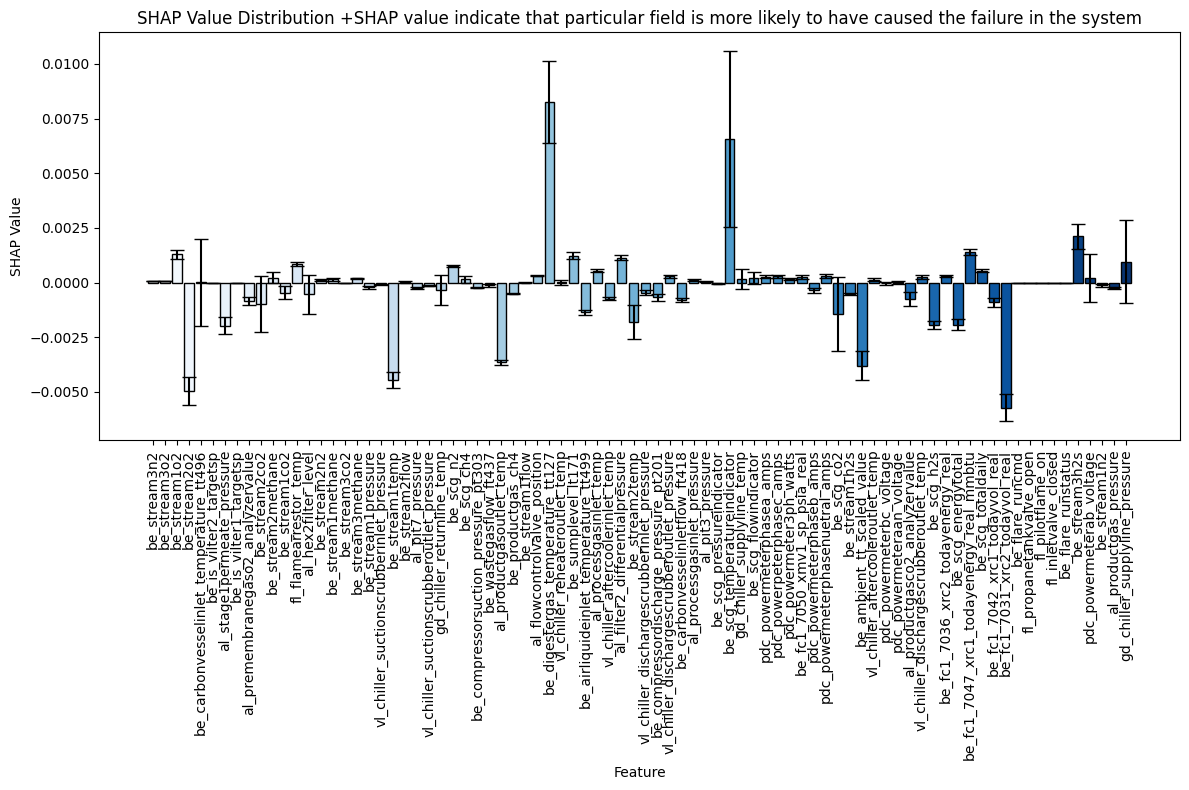

**Biogas Process Analysis**

The current biogas process data indicates a relatively stable

 system with typical values for ambient temperature, nitrogen and methane concentrations, and gas outlet temperature. However, there are a few areas of concern:

* **Power

 Meter Phase-Neutral Amps:** The elevated SHAP value for this parameter suggests that it may be contributing to the high probability of failure. This could indicate issues with the electrical system, such as overloading or equipment malfunction.

**Recommendations to Mitigate Potential Failures:**

* **Investigate the electrical system:** Check for

 any signs of overloading or equipment damage. Consider replacing or repairing any faulty components.
* **Monitor ambient temperature:** Ensure that the ambient temperature remains within the optimal range for the biogas process. This may involve adjusting the heating or cooling systems.
* **Optimize biogas composition:** Maintain the desired concentrations of nitrogen and methane in the biogas. This may involve adjusting feedstock composition or optimizing the digestion process.
* **Regular maintenance and inspections:** Schedule regular maintenance and inspections to identify and address any potential issues before they escalate into failures.
* **Implement redundancy measures:** Consider incorporating backup systems or components to ensure continuity of operation in the event of

 a failure.

By addressing these areas, it is possible to reduce the risk of potential failures and ensure the smooth and efficient operation of the biogas process.

Potential system failure detected! Probability: 0.961411297
Field variations contributing to the failure:
- be_stream3n2: Importance = 5.913378730165449e-05
- be_stream3o2: Importance = 9.63837460738189e-05
- be_stream1o2: Importance = 0.0013846491250430572
- be_stream2methane: Importance = 4.2645222972529894e-05
- fl_flamearrestor_temp: Importance = 0.0009033331901962882
- be_stream2n2: Importance = 8.078021444354832e-05
- be_stream1methane: Importance = 8.92237734116793e-05
- be_stream3methane: Importance = 0.00016740655643189252
- be_stream2flow: Importance = 4.940014363798992e-05
- be_scg_n2: Importance = 0.0007744032618006252
- be_scg_ch4: Importance = 3.339271761348712e-05
- be_stream1flow: Importance = 5.057114735871551e-06
- al_flowcontrolvalve_position: Importance = 0.0003046283634971134
- be_digestergas_temperature_tt127: Importance = 0.009218404816694618
- vl_chiller_reheateroutlet_temp: Importance = 0.00010635303926170228
- be_sumplevel_lt171: Importance = 0.001452304626562

In [24]:
 # Set the desired window size
trainer_generator=get_latest_train_data(window_size=datawindow,data=data_new)
run_no=0
while True:
  run_no+=1
  # Get the latest system data
  new_data = next(trainer_generator)#stream in chunk of new data
  print(new_data.head())
  latest_pred_data=get_latest_system_data(new_data)#new data processed to get only training data
  # Predict failure probability
  failure_prob,prediction = predict_failure(latest_pred_data)
  model,shap_values=retrain_model(run_no,new_data)
  shaps=shap_values[0].tolist()
  prompt = f"""**Biogas Process Analysis with Gemini-Pro**
  Current Biogas Process Data and the corresponding SHAP values:
  * Ambient Temperature: {new_data.iloc[0][0]}°C with SHAP value:{shaps[0]}.
  * Nitrogen Concentration: {new_data.iloc[0][1]}% with SHAP value:{shaps[1]}.
  * Methane Concentration: {new_data.iloc[0][2]}% with SHAP value:{shaps[2]}.
  * Gas outlet Temperature: {new_data.iloc[0][3]}°C with SHAP value:{shaps[3]}.
  * Power Meter Phase-Neutral Amps: {new_data.iloc[0][4]}A with SHAP value:{shaps[4]}.
  Potential Failure chance after {-shift} steps:{failure_prob*100}%
  **Based on the data above, can you analyze the current state of the Biogas process and recommend actions to prevent or mitigate potential failures? Note that i am using an LSTM model to predict the failure probabilty also and i have also provided the SHAP values.[Only output the analysis do not mention the LSTM or SHAP]**"""
  gemini(prompt)
  if failure_prob > threshold:
      print(f'Potential system failure detected! Probability: {failure_prob:.9f}')
      print('Field variations contributing to the failure:')
      for feature, importance_list in zip(X.columns, shap_values[0].tolist()):
            for importance in importance_list:
                if importance > 0:
                    #if abs(importance) > 0.001:  # Print only if the absolute SHAP value is greater than 0.001
                    print(f'- {feature}: Importance = {"{}".format(importance)}')
      break

  else:
      print(f'System operating normally. Failure probabilty: {failure_prob:.2f}')



In [42]:
datas = pd.read_csv('/content/drive/MyDrive/Data_ML/temperory_dataset_with_timestamp_test_new.csv')
datas = datas.dropna()
time=datas["timestamp"]
datas=datas.drop("timestamp",axis=1)
actual_targets = datas[target]
d_data=get_latest_system_data(datas)
_,predictions= predict_failure(d_data)
print(actual_targets)

315/315 [==============================] - 1s 2ms/step
0        0
1        0
2        0
3        0
4        0
        ..
10075    0
10076    0
10077    0
10078    0
10079    0
Name: be_system_abort_shutdown, Length: 10080, dtype: int64


In [43]:
import matplotlib.pyplot as plt

# Assuming 'target' is the column containing actual target values

plt.figure(figsize=(10, 8))  # Increase the figure height to accommodate two subplots


<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

In [72]:
import numpy as np

# Assuming predictions is a 1D NumPy array

window_size = -shift
max_probs = np.zeros(len(predictions))  # Pre-allocate memory for the new array

# Loop through the predictions array with a sliding window, adjusting for out-of-bounds indices
for i in range(len(max_probs)):

    window_start = max(0, i - window_size)  # Ensure window_start is not negative
    #print(i, window_start)
    window_end = i

    # Handle empty windows:
    if (window_end-window_start) == 0:  # If window_start and window_end are the same, the window is empty
        max_probs[i] = 0  # Assign 0 to the maximum probability (or any other appropriate value)
    else:
        #print(window_start,window_end)
        #print(predictions[window_start+1:window_end+10])
        max_probs[i] = np.max(predictions[window_start:window_end+1])  # Calculate the maximum for non-empty windows


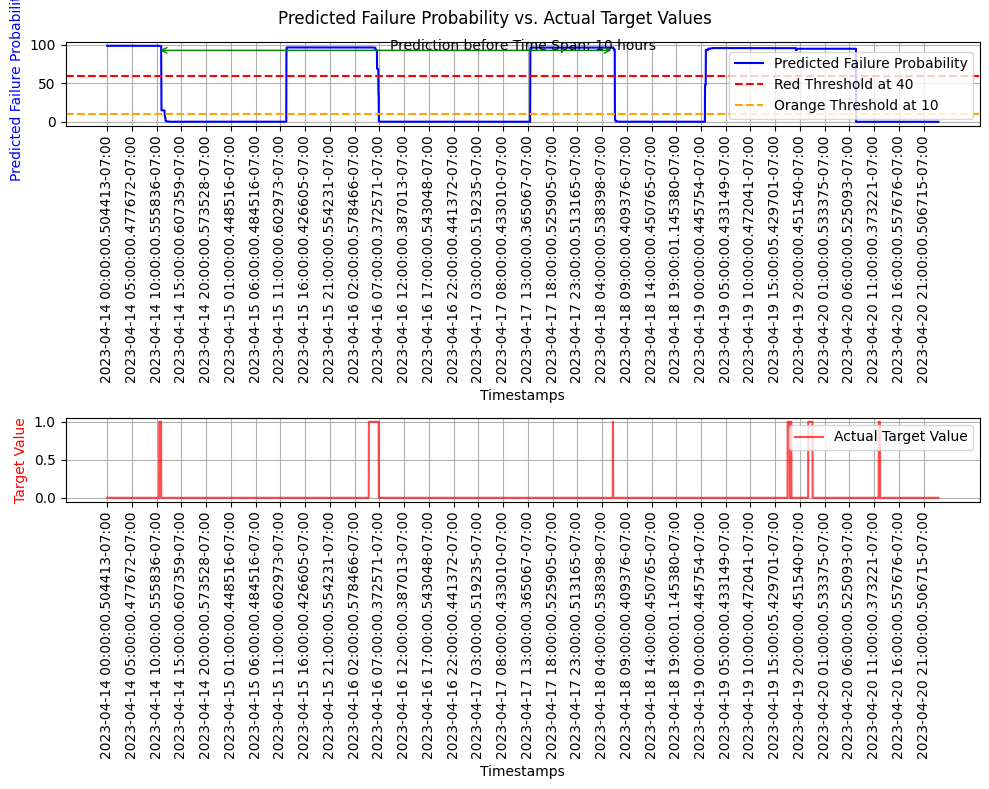

In [76]:
import matplotlib.pyplot as plt

# Assuming 'target' is the column containing actual target values

plt.figure(figsize=(10, 8))  # Increase the figure height to accommodate two subplots

# Ensure predictions are scaled to a meaningful range (e.g., 0-700%)

predictions_scaled = max_probs * 100

# Create the first subplot for predicted probability

plt.subplot(2, 1, 1)  # (rows, columns, subplot_index)

start_idx = 0

end_idx = 15000

plt.plot(time.iloc[start_idx:end_idx], predictions_scaled[start_idx:end_idx], color='blue', label='Predicted Failure Probability')

plt.axhline(y=60, color='red', linestyle='--', label='Red Threshold at 40')

plt.axhline(y=10, color='orange', linestyle='--', label='Orange Threshold at 10')

plt.ylabel('Predicted Failure Probability', color='blue')

plt.xlabel("Timestamps")

plt.xticks(time.iloc[start_idx:].values[::300], rotation=90)  # Set x-ticks with a step of 300 and rotate labels

# Add the double-sided arrow for the time span

arrow_x_start = 0.1
arrow_x_end = 0.6
arrow_y = 0.9
text_y = arrow_y + 0.01  # Raise the text slightly above the arrow

plt.annotate('Prediction before Time Span: 10 hours', xy=(0.5, text_y), xycoords='axes fraction', ha='center', fontsize=10)

plt.annotate('', xy=(arrow_x_start, arrow_y), xytext=(arrow_x_end, arrow_y), xycoords='axes fraction', textcoords='axes fraction',
             arrowprops=dict(arrowstyle='<->', color='green'))
plt.legend()

plt.grid(True)

# Create the second subplot for actual target values

plt.subplot(2, 1, 2)  # (rows, columns, subplot_index)

plt.plot(time.iloc[start_idx:end_idx], actual_targets[start_idx:end_idx], color='red', label='Actual Target Value', alpha=0.7)

plt.ylabel('Target Value', color='red')

plt.xlabel("Timestamps")

plt.xticks(time.iloc[start_idx:].values[::300], rotation=90)  # Set x-ticks with a step of 300 and rotate labels

plt.legend()

plt.grid(True)


plt.suptitle("Predicted Failure Probability vs. Actual Target Values")  # Add an overall title

plt.tight_layout()  # Adjust spacing between subplots

plt.show()

In [86]:
# Assuming actual_targets and time are NumPy arrays
prev_value = None
for i, (value, timestamp) in enumerate(zip(actual_targets, time)):
    if prev_value is None:
        prev_value = value
        continue

    if value != prev_value and (value == 0 or value == 1) and (prev_value == 0 or prev_value == 1):
        print(f"Transition from {prev_value} to {value} at {timestamp}")

    prev_value = value

Transition from 0 to 1 at 2023-04-14 10:30:00.352264-07:00
Transition from 1 to 0 at 2023-04-14 10:54:00.412011-07:00
Transition from 0 to 1 at 2023-04-16 04:52:00.468601-07:00
Transition from 1 to 0 at 2023-04-16 06:52:00.454591-07:00
Transition from 0 to 1 at 2023-04-18 06:11:00.392951-07:00
Transition from 1 to 0 at 2023-04-18 06:14:00.350464-07:00
Transition from 0 to 1 at 2023-04-19 17:30:00.508648-07:00
Transition from 1 to 0 at 2023-04-19 17:57:00.421015-07:00
Transition from 0 to 1 at 2023-04-19 18:07:00.375016-07:00
Transition from 1 to 0 at 2023-04-19 18:09:00.444071-07:00
Transition from 0 to 1 at 2023-04-19 18:13:00.497751-07:00
Transition from 1 to 0 at 2023-04-19 18:14:00.556506-07:00
Transition from 0 to 1 at 2023-04-19 21:40:00.481820-07:00
Transition from 1 to 0 at 2023-04-19 22:33:00.350367-07:00
Transition from 0 to 1 at 2023-04-20 11:55:00.525570-07:00
Transition from 1 to 0 at 2023-04-20 12:10:00.557474-07:00


In [88]:
from datetime import datetime

# Assuming predictions_scaled and time are NumPy arrays
prev_value = None
for i, (pred_value, timestamp) in enumerate(zip(predictions_scaled, time)):
    # Remove extra characters before parsing (if applicable)
    clean_timestamp = timestamp.split(".")[0]
    # Convert timestamp to datetime format
    datetime_obj = datetime.strptime(clean_timestamp, "%Y-%m-%d %H:%M:%S")

    if prev_value is None:
        prev_value = pred_value
        continue

    if (pred_value >= 65 and prev_value < 65) or (pred_value < 65 and prev_value >= 65):
        print(f"Transition from {prev_value:.2f} to {pred_value:.2f} at {datetime_obj}")

    prev_value = pred_value

Transition from 70.86 to 14.86 at 2023-04-14 10:56:00
Transition from 61.83 to 86.91 at 2023-04-15 12:13:00
Transition from 67.37 to 35.67 at 2023-04-16 06:48:00
Transition from 41.23 to 70.99 at 2023-04-17 13:30:00
Transition from 93.73 to 32.31 at 2023-04-18 06:35:00
Transition from 47.81 to 92.61 at 2023-04-19 00:58:00
Transition from 94.79 to 0.00 at 2023-04-20 07:20:00


In [93]:
#Table
from tabulate import tabulate

column_titles = ["No.", "Down time begins", "Down time ends", "Alarm start", "Alarm end", "Alarm duration"]
data_row_1 = [1, "2023-04-16 04:52:00","2023-04-16 06:52:00" , "2023-04-15 12:13:00", "2023-04-16 06:48:00"]  # Replace with your data
data_row_2 = [2, "2023-04-18 06:11:00", "2023-04-18 06:14:00", "2023-04-17 13:30:00", "2023-04-18 06:35:00"]  # Replace with your data
data_row_3 = [3, "2023-04-19 17:30:00", "2023-04-19 22:33:00", "2023-04-19 00:58:00", "2023-04-20 07:20:00"]  # Replace with your data
# Calculate the alarm duration for each row
alarm_durations = []
for row in [data_row_1, data_row_2, data_row_3]:
    alarm_start = datetime.strptime(row[3], "%Y-%m-%d %H:%M:%S")
    alarm_end = datetime.strptime(row[4], "%Y-%m-%d %H:%M:%S")
    alarm_duration = alarm_end - alarm_start
    alarm_durations.append(str(alarm_duration))

# Combine the column titles and data rows with alarm durations
table_data = [column_titles]
for row, duration in zip([data_row_1, data_row_2, data_row_3], alarm_durations):
    table_data.append(row + [duration])

# Print the table
print(tabulate(table_data, headers="firstrow", tablefmt="grid"))
print("!Overlap of failures cause the alarm to last longer!")


+-------+---------------------+---------------------+---------------------+---------------------+------------------+
|   No. | Down time begins    | Down time ends      | Alarm start         | Alarm end           | Alarm duration   |
+=======+=====================+=====================+=====================+=====================+==================+
|     1 | 2023-04-16 04:52:00 | 2023-04-16 06:52:00 | 2023-04-15 12:13:00 | 2023-04-16 06:48:00 | 18:35:00         |
+-------+---------------------+---------------------+---------------------+---------------------+------------------+
|     2 | 2023-04-18 06:11:00 | 2023-04-18 06:14:00 | 2023-04-17 13:30:00 | 2023-04-18 06:35:00 | 17:05:00         |
+-------+---------------------+---------------------+---------------------+---------------------+------------------+
|     3 | 2023-04-19 17:30:00 | 2023-04-19 22:33:00 | 2023-04-19 00:58:00 | 2023-04-20 07:20:00 | 1 day, 6:22:00   |
+-------+---------------------+---------------------+-----------

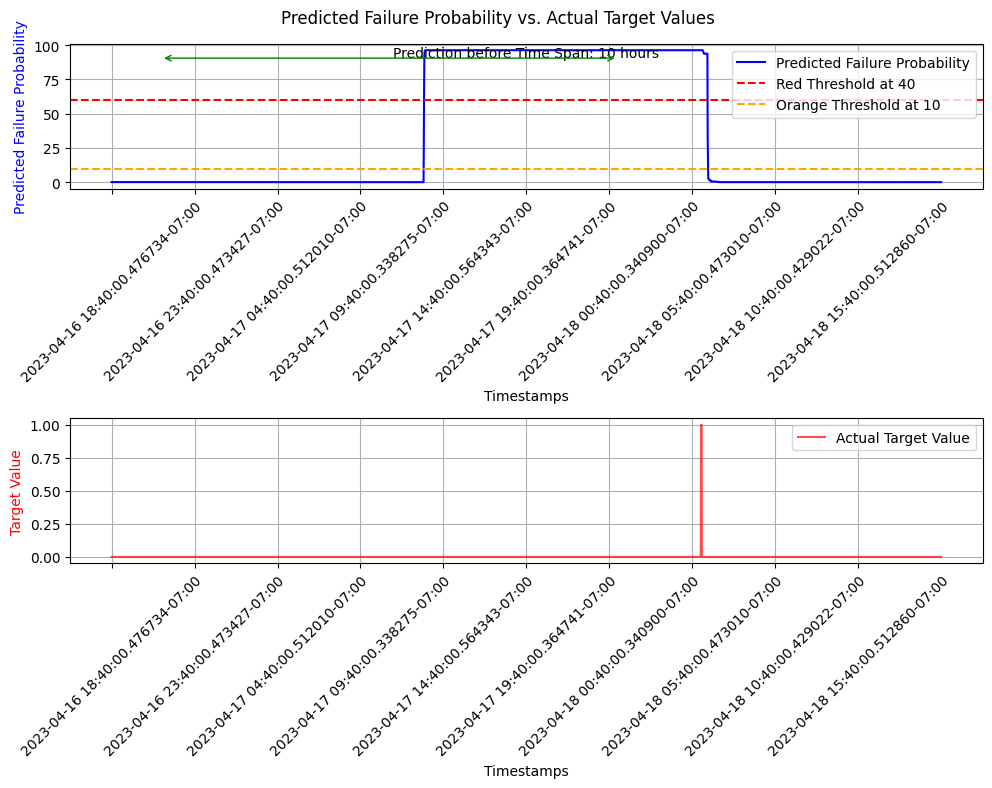

In [80]:
import matplotlib.pyplot as plt

# Assuming 'target' is the column containing actual target values

plt.figure(figsize=(10, 8))  # Increase the figure height to accommodate two subplots

# Ensure predictions are scaled to a meaningful range (e.g., 0-700%)

predictions_scaled = max_probs * 100

# Create the first subplot for predicted probability

plt.subplot(2, 1, 1)  # (rows, columns, subplot_index)

start_idx = 4000

end_idx = 7000

plt.plot(time.iloc[start_idx:end_idx], predictions_scaled[start_idx:end_idx], color='blue', label='Predicted Failure Probability')

plt.axhline(y=60, color='red', linestyle='--', label='Red Threshold at 40')

plt.axhline(y=10, color='orange', linestyle='--', label='Orange Threshold at 10')

plt.ylabel('Predicted Failure Probability', color='blue')

plt.xlabel("Timestamps")

plt.xticks(time.iloc[start_idx:end_idx].values[::300], rotation=45)  # Set x-ticks with a step of 300 and rotate labels

# Add the double-sided arrow for the time span

arrow_x_start = 0.1
arrow_x_end = 0.6
arrow_y = 0.9
text_y = arrow_y + 0.01  # Raise the text slightly above the arrow

plt.annotate('Prediction before Time Span: 10 hours', xy=(0.5, text_y), xycoords='axes fraction', ha='center', fontsize=10)

plt.annotate('', xy=(arrow_x_start, arrow_y), xytext=(arrow_x_end, arrow_y), xycoords='axes fraction', textcoords='axes fraction',
             arrowprops=dict(arrowstyle='<->', color='green'))
plt.legend()

plt.grid(True)

# Create the second subplot for actual target values

plt.subplot(2, 1, 2)  # (rows, columns, subplot_index)

plt.plot(time.iloc[start_idx:end_idx], actual_targets[start_idx:end_idx], color='red', label='Actual Target Value', alpha=0.7)

plt.ylabel('Target Value', color='red')

plt.xlabel("Timestamps")

plt.xticks(time.iloc[start_idx:end_idx].values[::300], rotation=45)  # Set x-ticks with a step of 300 and rotate labels

plt.legend()

plt.grid(True)


plt.suptitle("Predicted Failure Probability vs. Actual Target Values")  # Add an overall title

plt.tight_layout()  # Adjust spacing between subplots

plt.show()

# **Correlation test for the dataset**

In [61]:
data_corr=pd.read_csv('/content/drive/MyDrive/Data_ML/temperory_dataset_with_timestamp_test_corr.csv')

In [62]:
import matplotlib.pyplot as plt
# Define the target variable name (replace with your actual target variable)
target_variable =target
data=data_corr
data=data.drop("timestamp",axis=1)
# Select features and target variable (consider excluding the index column if present)
features = data.columns.difference([target_variable])  # Exclude target variable from features
df_filtered = data[features] .copy()  # Optional: Create a copy to avoid modifying original data

# Calculate the correlation matrix
correlation_matrix = df_filtered.corr(method='spearman')  # Spearman rank correlation for non-normal data

# Display the correlation matrix
print(correlation_matrix)

# # Generate a heatmap for visualization (optional)
# plt.matshow(correlation_matrix, cmap=plt.cm.bwr)
# plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=45)
# plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
# plt.colorbar()
# plt.show()

                                           al_cr_7_do  \
al_cr_7_do                                        NaN   
al_filter2_differentialpressure                   NaN   
al_flowcontrolvalve_position                      NaN   
al_fv_3a_2b_do                                    NaN   
al_fv_9_cmd                                       NaN   
...                                               ...   
vl_chiller_dischargescrubberoutlet_temp           NaN   
vl_chiller_recyclevalve_position                  NaN   
vl_chiller_reheateroutlet_temp                    NaN   
vl_chiller_suctionscrubberinlet_pressure          NaN   
vl_chiller_suctionscrubberoutlet_pressure         NaN   

                                           al_filter2_differentialpressure  \
al_cr_7_do                                                             NaN   
al_filter2_differentialpressure                                   1.000000   
al_flowcontrolvalve_position                                      0.410663   
al_

In [63]:
# Define filename and desired image size (adjust width and height as needed)
filename = "correlation_heatmap.png"
fig, ax = plt.subplots(figsize=(50, 40))  # Set figure size for better readability

# Generate the heatmap
heatmap = ax.matshow(correlation_matrix, cmap=plt.cm.bwr)

# Customize labels and colorbar
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=45)
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
plt.colorbar(heatmap)

# Save the heatmap as an image
fig.savefig(filename, dpi=300, bbox_inches='tight')  # Adjust dpi for higher resolution

print(correlation_matrix)  # Still print the correlation matrix for reference
plt.close(fig)  # Close the plot window (optional)

                                           al_cr_7_do  \
al_cr_7_do                                        NaN   
al_filter2_differentialpressure                   NaN   
al_flowcontrolvalve_position                      NaN   
al_fv_3a_2b_do                                    NaN   
al_fv_9_cmd                                       NaN   
...                                               ...   
vl_chiller_dischargescrubberoutlet_temp           NaN   
vl_chiller_recyclevalve_position                  NaN   
vl_chiller_reheateroutlet_temp                    NaN   
vl_chiller_suctionscrubberinlet_pressure          NaN   
vl_chiller_suctionscrubberoutlet_pressure         NaN   

                                           al_filter2_differentialpressure  \
al_cr_7_do                                                             NaN   
al_filter2_differentialpressure                                   1.000000   
al_flowcontrolvalve_position                                      0.410663   
al_

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


Correlation Matrix (Positive Correlated Features):
                                           al_hex2filter_level  \
al_hex2filter_level                                   1.000000   
al_premembranegaso2_analyzervalue                    -0.651324   
al_processgasinlet_temp                               0.663978   
al_productgaso2_analyzervalue                        -0.452515   
al_productgasoutlet_temp                              0.119704   
be_aircomp1_runcmd                                    0.812795   
be_aircomp1_runstatus                                 0.812795   
be_airliquideinlet_temperature_tt499                  0.767377   
be_ambient_tt_scaled_value                           -0.582696   
be_carbonvesselinlet_temperature_tt496                0.330687   
be_compressorsuction_pressure_pt303                  -0.381229   
be_condensatelevel_lt711                              0.422344   
be_dginletisolationvalve105_closed                    0.199055   
be_digestergas_temperatur

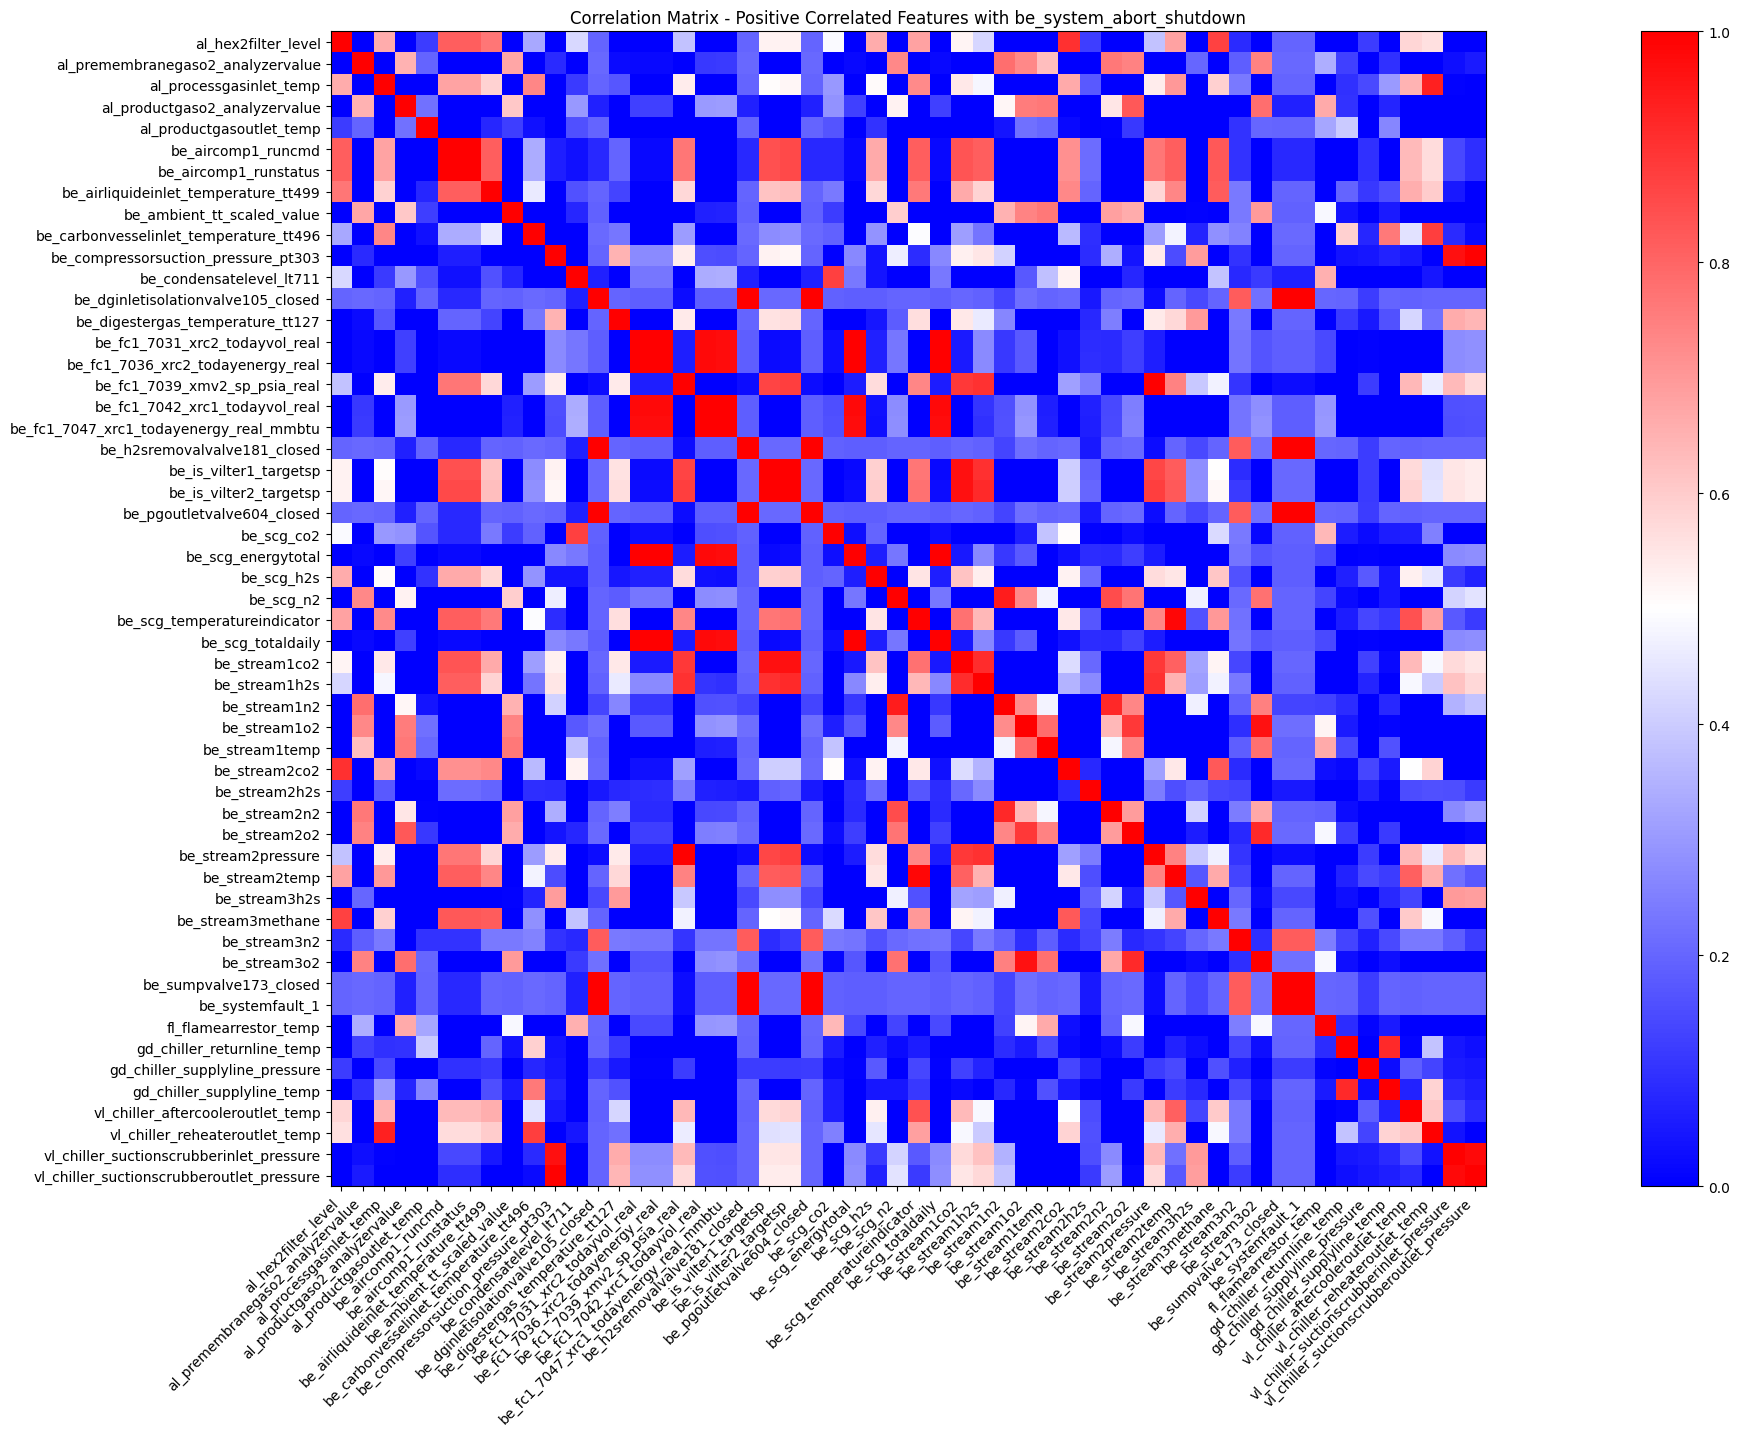

In [64]:
import matplotlib.pyplot as plt
import numpy as np

# Define the target variable name (replace with your actual target variable)
target_variable = target
data = data_corr
data = data.drop("timestamp", axis=1)

# Select features and target variable (consider excluding the index column if present)
features = data.columns.difference([target_variable])

# Exclude target variable from features
df_filtered = data[features].copy()  # Optional: Create a copy to avoid modifying original data

# Calculate the correlation matrix
correlation_matrix = df_filtered.corr(method='spearman')

# Calculate the correlation with the target variable
target_correlation = data[features].corrwith(data[target_variable], method='spearman')

# Filter out features with correlation <= 0
positive_corr_features = target_correlation[target_correlation > 0].index

# Create a new correlation matrix with only positive correlated features
positive_corr_matrix = correlation_matrix.loc[positive_corr_features, positive_corr_features]

# Display the correlation matrix with positive correlated features
print("Correlation Matrix (Positive Correlated Features):")
print(positive_corr_matrix)
# Generate a heatmap for visualization (optional)
plt.figure(figsize=(40, 15))

# Create the heatmap using imshow with masking:
heatmap = plt.imshow(positive_corr_matrix, cmap=plt.cm.bwr, vmin=0, vmax=1)
mask = np.any(np.ones_like(positive_corr_matrix, dtype=bool))
heatmap.set_visible(mask)  # Apply the mask to the heatmap

plt.xticks(range(len(positive_corr_matrix.columns)), positive_corr_matrix.columns, rotation=45, ha='right')
plt.yticks(range(len(positive_corr_matrix.columns)), positive_corr_matrix.columns)
plt.colorbar()
plt.title(f"Correlation Matrix - Positive Correlated Features with {target_variable}")
plt.show()

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


Highly Correlated Features with be_system_abort_shutdown:
Index(['al_fv_3a_2b_do', 'al_fv_9_cmd', 'be_airliquide_runcmd',
       'be_airliquide_runstatus', 'be_dginletisolationvalve105_closed',
       'be_dginletisolationvalve105_open', 'be_gdchiller_runcmd',
       'be_h2sremovalvalve181_closed', 'be_h2sremovalvalve181_open',
       'be_pgoutletvalve604_closed', 'be_pgoutletvalve604_open',
       'be_stream3n2', 'be_sumpvalve173_closed', 'be_sumpvalve173_open',
       'be_system_running', 'be_systemfault_1', 'be_vilterchiller_runcmd',
       'be_vilterchiller_runstatus', 'be_viltercomp1_runcmd',
       'be_viltercomp1_runstatus', 'be_viltercomp2_faultstatus',
       'be_viltercomp2_runcmd', 'be_viltercomp2_runstatus'],
      dtype='object')


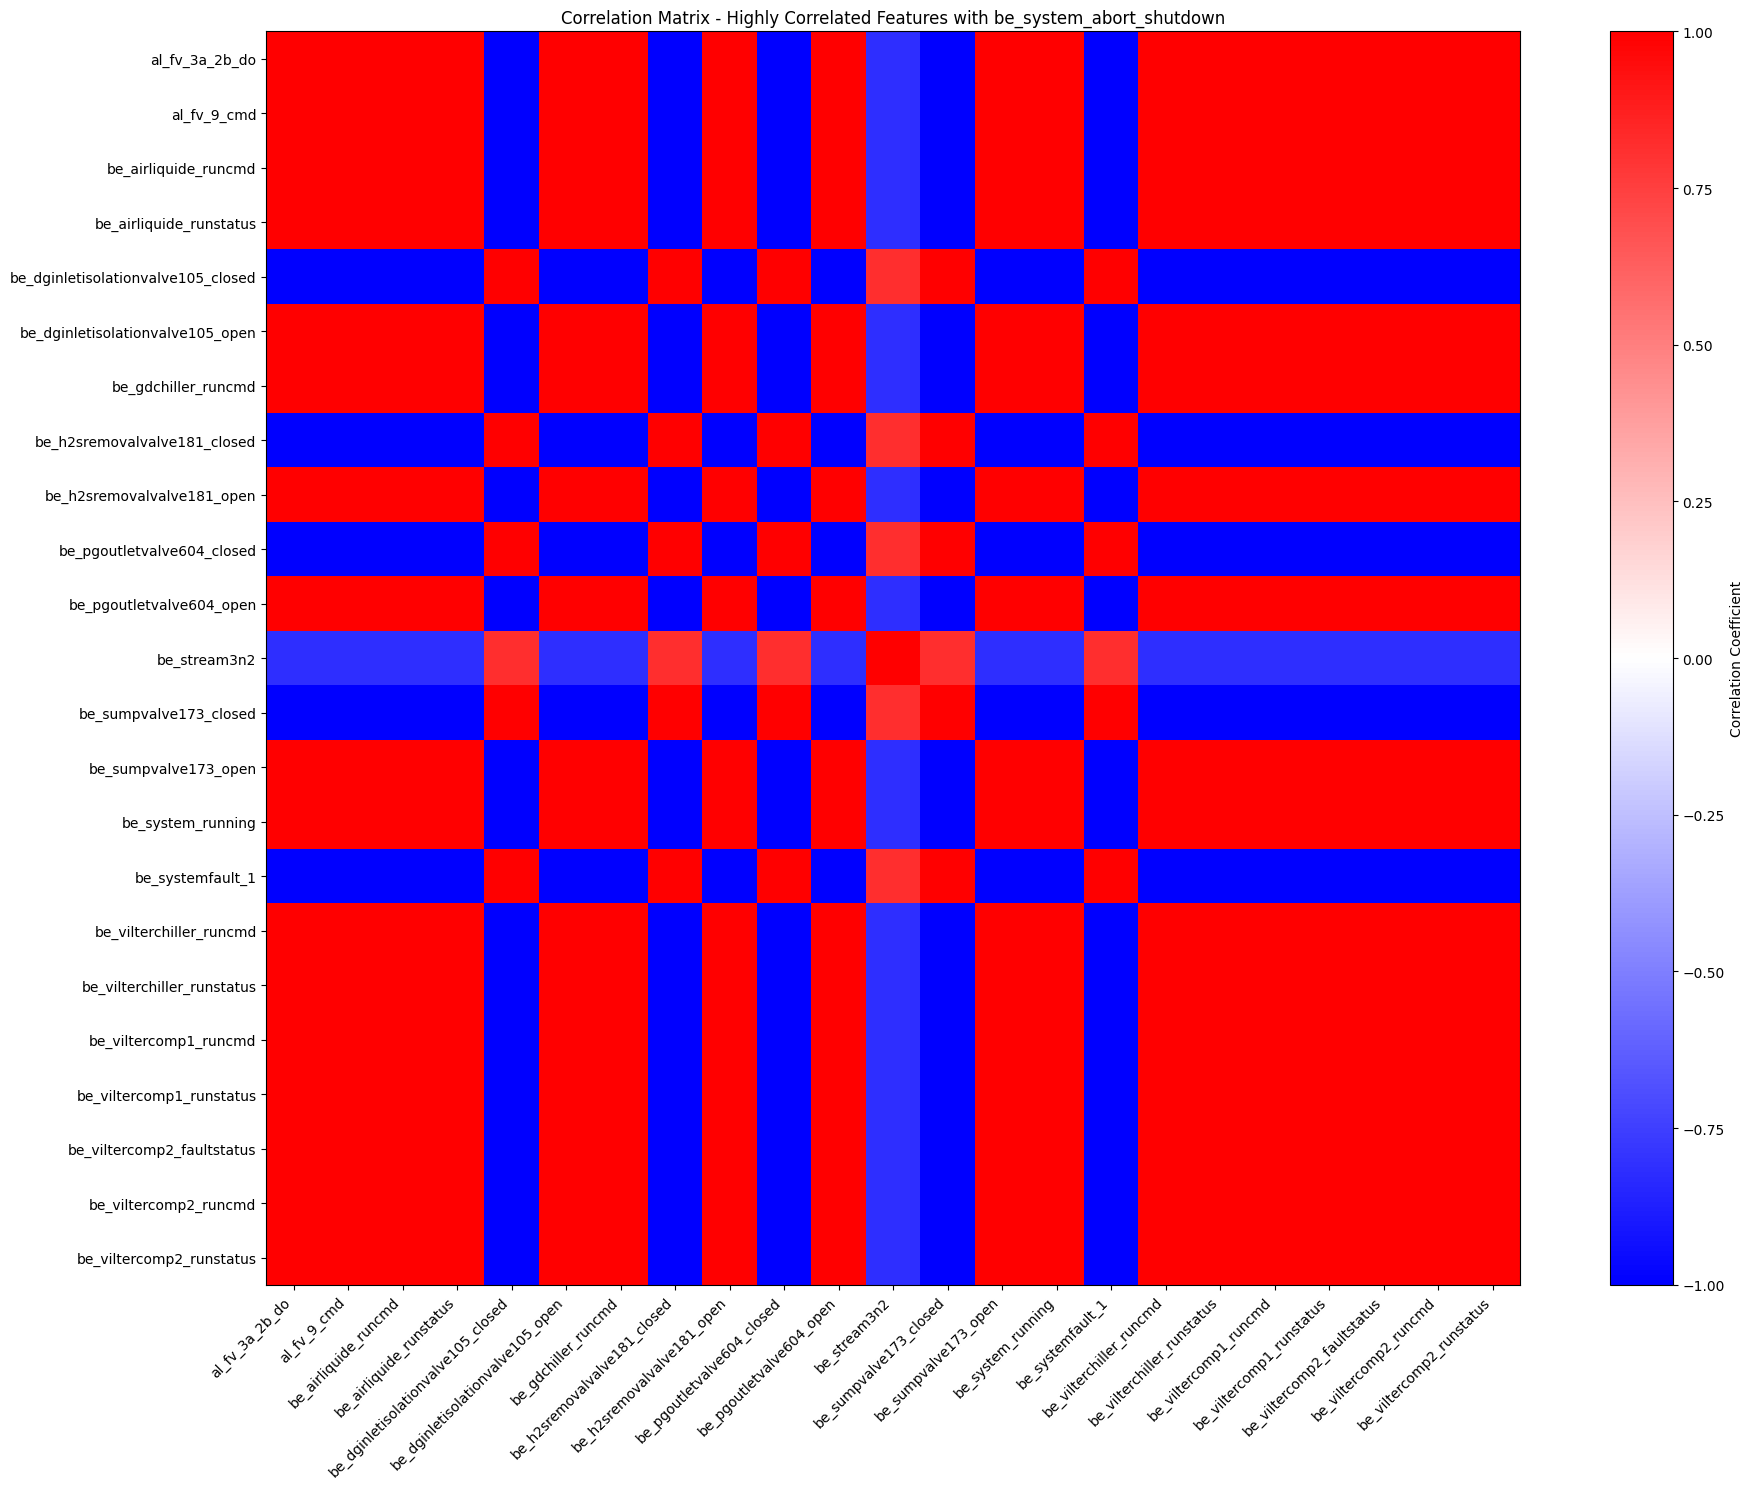

In [65]:
import matplotlib.pyplot as plt
import numpy as np

# Define the target variable name (replace with your actual target variable)
target_variable = target
data = data_corr
data=data.dropna()
data = data.drop("timestamp", axis=1)  # Drop timestamp column (assuming it exists)

# Select features and target variable (consider excluding the index column if present)
features = data.columns.difference([target_variable])

# Exclude target variable from features
df_filtered = data[features].copy()  # Optional: Create a copy to avoid modifying original data

# Calculate the correlation matrix
correlation_matrix = df_filtered.corr(method='spearman')

# Calculate the correlation with the target variable
target_correlation = data[features].corrwith(data[target_variable], method='spearman')

# Filter features with high correlation (both positive and negative)
filtered_features = target_correlation[np.abs(target_correlation) > 0.8].index

# Create a new correlation matrix with filtered features
filtered_corr_matrix = correlation_matrix.loc[filtered_features, filtered_features]

# Display results
print("Highly Correlated Features with", target_variable, end=":\n")
print(filtered_features)

# Heatmap with mask (optional)
plt.figure(figsize=(20, 15))  # Increase figure size

# Create the heatmap using imshow with masking:
heatmap = plt.imshow(filtered_corr_matrix, cmap=plt.cm.bwr, vmin=-1, vmax=1)
mask = np.any(np.ones_like(filtered_corr_matrix, dtype=bool))
heatmap.set_visible(mask)  # Apply the mask to the heatmap

# Label adjustments
plt.xticks(range(len(filtered_corr_matrix.columns)), filtered_corr_matrix.columns, rotation=45, ha='right')
plt.yticks(range(len(filtered_corr_matrix.columns)), filtered_corr_matrix.columns)
plt.colorbar(label="Correlation Coefficient")
plt.title(f"Correlation Matrix - Highly Correlated Features with {target_variable}")
plt.tight_layout()  # Improve layout for better readability

# Save the plot (replace 'heatmap.png' with your desired filename)
plt.savefig('heatmap.png')
plt.show()


# **List of correlation to Target value**

Index(['be_stream3n2', 'be_stream3o2', 'be_stream1o2', 'be_stream2o2',
       'be_carbonvesselinlet_temperature_tt496', 'be_is_vilter2_targetsp',
       'al_stage1permeate_pressure', 'be_is_vilter1_targetsp',
       'al_premembranegaso2_analyzervalue', 'be_stream2co2',
       'be_stream2methane', 'be_stream1co2', 'fl_flamearrestor_temp',
       'al_hex2filter_level', 'be_stream2n2', 'be_stream1methane',
       'be_stream3co2', 'be_stream3methane', 'be_stream1pressure',
       'vl_chiller_suctionscrubberinlet_pressure', 'be_stream1temp',
       'be_stream2flow', 'al_pit7_pressure',
       'vl_chiller_suctionscrubberoutlet_pressure',
       'gd_chiller_returnline_temp', 'be_scg_n2', 'be_scg_ch4',
       'be_compressorsuction_pressure_pt303', 'be_wastegasflow_ft437',
       'al_productgasoutlet_temp', 'be_productgas_ch4', 'be_stream1flow',
       'al_flowcontrolvalve_position', 'be_digestergas_temperature_tt127',
       'vl_chiller_reheateroutlet_temp', 'be_sumplevel_lt171',
       'be_ai

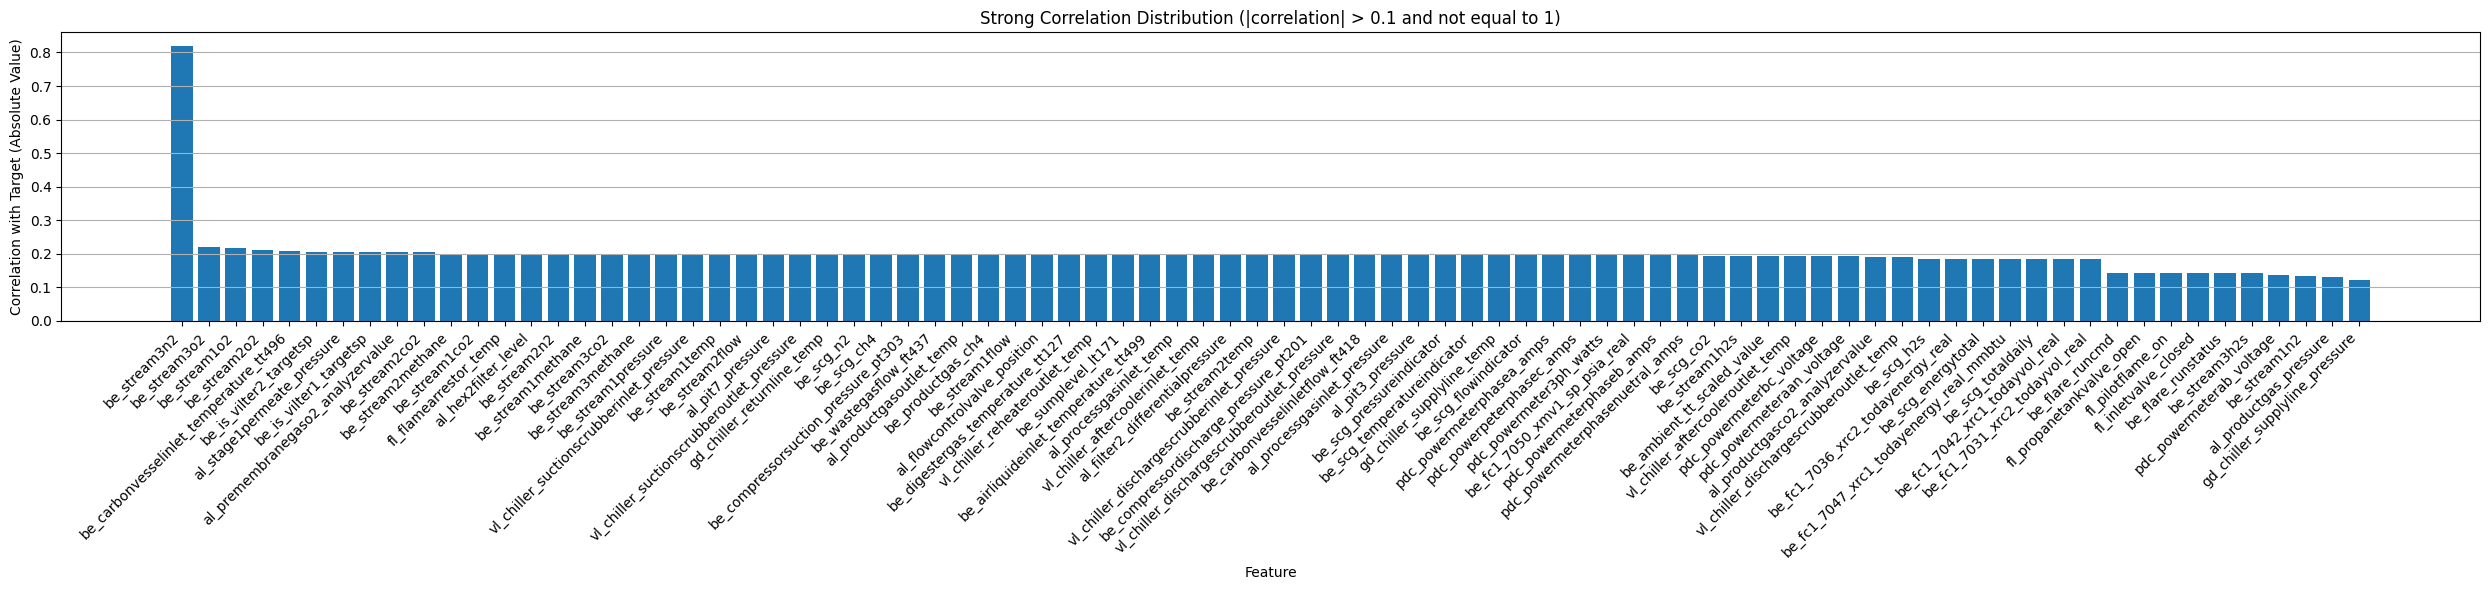

In [66]:
# Filter features with correlation > 0.7 or < -0.7 (absolute values)
filtered_corr = target_correlation[((target_correlation > 0.1) & (target_correlation != 1)) | ((target_correlation < -0.1) & (target_correlation != -1))]

# Sort filtered correlations (if any)
if not filtered_corr.empty:
  sorted_corr = filtered_corr.abs().sort_values(ascending=False)  # Sort by absolute values
  # Prepare data for histogram (optional)
  features = sorted_corr.index.to_numpy()   # Convert index to NumPy array
  correlations = sorted_corr.to_numpy()   # Convert Series to NumPy array
  print(sorted_corr.keys())
  # Print correlation values and corresponding column names
  print("Strong Correlations with Target Variable (|correlation| > 0.7):")
  for feature, correlation in sorted_corr.items():
    print(f"{feature}: {correlation:.4f}")

  # Create the histogram (optional)
  plt.figure(figsize=(25, 6))
  plt.bar(features, correlations)
  plt.xticks(rotation=45, ha='right')  # Rotate feature labels for readability
  plt.xlabel("Feature")
  plt.ylabel("Correlation with Target (Absolute Value)")
  plt.title("Strong Correlation Distribution (|correlation| > 0.1 and not equal to 1)")
  plt.grid(axis='y')  # Add gridlines for better visualization
  plt.tight_layout()
  plt.show()
else:
  print("No strong correlations found (|correlation| > 0.7).")